In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 18.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools
import pyLDAvis
import pyLDAvis.gensim #dont skip this
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download("stopwords")

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SEM 8/NLP/Assignment PPT/demonetization-tweets.csv", encoding = "cp1252")
print(df.shape)
df.head()

(8000, 15)


,Unnamed: 0,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,801495656976318464,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,801495654778413057,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,801495544266821632,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,801495527024160768,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,801495445583360002,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8000 non-null   int64  
 1   text           8000 non-null   object 
 2   favorited      8000 non-null   bool   
 3   favoriteCount  8000 non-null   int64  
 4   replyToSN      316 non-null    object 
 5   created        8000 non-null   object 
 6   truncated      8000 non-null   bool   
 7   replyToSID     226 non-null    float64
 8   id             8000 non-null   int64  
 9   replyToUID     316 non-null    float64
 10  statusSource   8000 non-null   object 
 11  screenName     8000 non-null   object 
 12  retweetCount   8000 non-null   int64  
 13  isRetweet      8000 non-null   bool   
 14  retweeted      8000 non-null   bool   
dtypes: bool(4), float64(2), int64(4), object(5)
memory usage: 718.9+ KB


In [ ]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'RT @kanimozhi: Thanks to #demonetization 75% reduction in crime rate in India. Black money seems to be the sole reason 4 all problems in In…'

In [ ]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: India’s #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have strings such as RT, @xyz, etc. Some have URLs, punctuation marks, smileys etc. The following code cleans the data to handle many of these issues.


## **DATA CLEANING & PREPROCESSING**

In [ ]:
# remove URLs
def remove_URL(x):
    return x.replace(r'https[a-zA-Z0-9]*',"",regex=True)

#clean tweet text
def clean_tweets(tweet_col):
    df=pd.DataFrame({'tweet':tweet_col})
    df['tweet']=df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet']=df['tweet'].replace("  "," ")
    df['tweet']=df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet']=remove_URL(df['tweet'])
    df['tweet']=df['tweet'].str.lower()

    return(df)

cleaned_tweets=clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: india’s #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


In [ ]:
# tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):  # deacc=True removes punctuations
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

In [ ]:
def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Since tweets often contain slang words such as wat, rt, lol etc, we can append the stopwords with a list of such custom words and remove them.

In [ ]:
stop_words= stopwords.words('english') + list(string.punctuation)

words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d",
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']

#remove stop words, punctuations
stop_words = set(list(stopwords.words('english') + list(string.punctuation)+words_remove))
data_words= list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))

# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# spacy for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# sample lemmatized tweets
data_lemmatized[0:3]

[['critical',
  'question',
  'paytm',
  'inform',
  'demonetization',
  'edict',
  'pm',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 ['vote', 'demonetization', 'survey'],
 ['former', 'finsec', 'lambaste', 'demonetization', 'aadmi', 'listen']]

In [ ]:
# create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
corpus[0:3]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1)],
 [(3, 1), (13, 1), (14, 1)],
 [(3, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]

## **HYPERPARAMETER TUNING**

In [ ]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]

    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))

    return model_list,coherence_values

In [ ]:
# build models across a range of num_topics and alpha
num_topics_range=[2,6,10,15]
alpha_range=[0.01,0.1,1]
model_list, coherence_values=compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,
                                                      num_topics_range=num_topics_range,
                                                     alpha_range=alpha_range)

coherence_df = pd.DataFrame(coherence_values,columns=['alpha','num_topics','coherence_value'])

In [ ]:
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.316005
1,0.01,6,0.333094
2,0.01,10,0.379122
3,0.01,15,0.383301
4,0.10,2,0.336832
5,0.10,6,0.339355
6,0.10,10,0.354522
7,0.10,15,0.396005
8,1.00,2,0.368982
9,1.00,6,0.289678


In [ ]:
# plot
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))

    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0.30,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

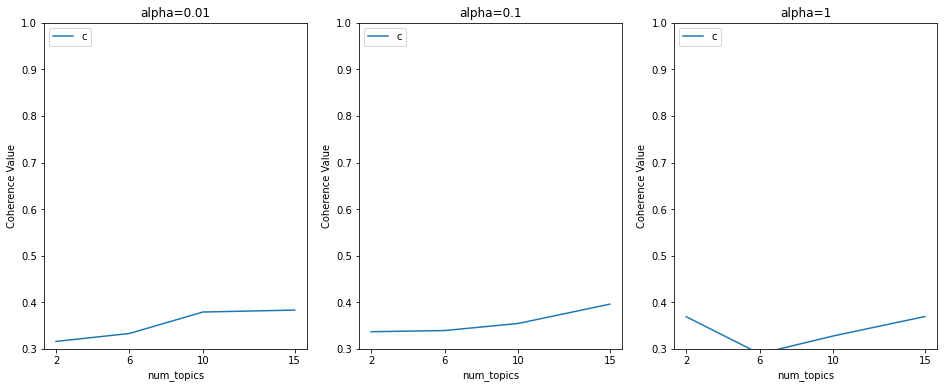

In [ ]:
# plot
plot_coherence(coherence_df,alpha_range,num_topics_range)

## **MODEL BUILDING**

In [ ]:
# Build LDA model with alpha=0.1 and 10 topics
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,\
                                          update_every=1,chunksize=100, passes=10, alpha=0.1, per_word_topics=True)

In [ ]:
# print keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.309*"bd" + 0.130*"demonetization" + 0.087*"ad" + 0.087*"tcoobqrhlnsl" + '
  '0.042*"note" + 0.031*"ed" + 0.025*"lakh" + 0.022*"prove" + 0.019*"seat" + '
  '0.017*"retain"'),
 (1,
  '0.113*"demonetization" + 0.068*"due" + 0.056*"need" + 0.052*"think" + '
  '0.036*"watch" + 0.031*"initiative" + 0.028*"lifeinsurance" + 0.028*"wise" + '
  '0.027*"secure" + 0.023*"farmer"'),
 (2,
  '0.135*"get" + 0.105*"demonetization" + 0.043*"shortage" + 0.042*"come" + '
  '0.038*"hour" + 0.038*"time" + 0.029*"wedding" + 0.028*"impact" + '
  '0.022*"end" + 0.019*"fund"'),
 (3,
  '0.136*"demonetization" + 0.027*"parliament" + 0.027*"affect" + '
  '0.026*"decision" + 0.024*"solution" + 0.024*"innovative" + 0.023*"crisis" + '
  '0.021*"street" + 0.021*"station" + 0.021*"detaiend"'),
 (4,
  '0.105*"bank" + 0.090*"demonetization" + 0.083*"money" + 0.044*"terrorist" + '
  '0.041*"bcoz" + 0.030*"black" + 0.025*"vote" + 0.020*"prominent" + '
  '0.020*"thane" + 0.014*"many"'),
 (5,
  '0.126*"people" + 0.

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4841000632961638


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.028598 -0.057987       1        1  12.675272
5     -0.005027 -0.074948       2        1  12.376451
9     -0.396314 -0.035401       3        1  12.073030
0     -0.000374  0.382076       4        1  10.378628
4      0.085498 -0.070247       5        1   9.826450
2      0.070482 -0.023042       6        1   9.669017
7      0.064443 -0.025488       7        1   9.200625
3      0.075288 -0.031670       8        1   8.455376
8      0.067965 -0.035674       9        1   8.327868
6      0.066637 -0.027620      10        1   7.017284, topic_info=                Term         Freq        Total Category  logprob  loglift
77                bd  2113.000000  2113.000000  Default  30.0000  30.0000
352               go   942.000000   942.000000  Default  29.0000  29.0000
71            people  1030.000000  1030.000000  Default  28.0000  28.0000
154              get   859.000000   859.000000  Default  27.0000  27.0000
0                amp   828.000000   828.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
3254        laudable    32.728935    33.641422  Topic10  -4.9519   2.6293
3255             map    32.728935    33.641422  Topic10  -4.9519   2.6293
3253   institutional    31.504945    32.417442  Topic10  -4.9900   2.6282
3252    architecture    30.409961    31.322472  Topic10  -5.0253   2.6272
3     demonetization   560.338185  7217.388344  Topic10  -2.1116   0.1011

[354 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1578      4  0.989603          abov
543       4  0.997608            ad
1550     10  0.984214       adverse
185       8  0.993221        affect
3963     10  0.990959  agricultural
...     ...       ...           ...
253       2  0.976335      withdraw
486       9  0.985114         world
3198      4  0.980875       xhizedw
1734      2  0.039307       youtube
1734      5  0.943379       youtube

[340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 1, 5, 3, 8, 4, 9, 7])

### Heaps law

In [ ]:
i = 0
tokens = text.split(" ")
words = set()
x,y = [],[]
for word in tokens:
    words.add(word)
    i += 1
    x.append(i)
    y.append(len(words))

plt.plot(x,y)

Zipf law

In [ ]:
text = """This is a sample text demonstrating Zipf's law. Zipf's law is an empirical law that states that in a large text corpus, the frequency of a word is inversely proportional to its rank. This means that a few words occur very frequently, while most words occur rarely. Zipf's law has been observed in various natural language texts and is a fundamental principle in linguistics and information retrieval."""

words = text.lower().split()

word_freq = {}
for word in words:
    word = ''.join(e for e in word if e.isalnum())
    if word:
        word_freq[word] = word_freq.get(word, 0) + 1

sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

word_ranks = {word[0]: rank + 1 for rank, word in enumerate(sorted_words)}

product_freq_rank = [rank * freq for word, freq, rank in zip(sorted_words, word_ranks.values(), sorted_words)]

print("Top 10 most common words:")
for word, freq in sorted_words[:10]:
    print(f"{word}: {freq}")
import matplotlib.pyplot as plt

frequencies = [freq for word, freq in sorted_words]
ranks = list(range(1, len(sorted_words) + 1))

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker='o', linestyle='-', color='b')
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Zipf's Law")
plt.grid(True)
plt.show()

